# Анализ ДТП в России на основе данных dtp-stat.ru
Это пример простого анализа статистики ДТП в России.
Посмотрим на следующие свойства данных:
- Структурированность данных
- Чистота данных
- Распределения наблюдаемых значений и признаков
- Корреляция по значений по признакам

## Шаг 1. Подготовка pandas фрейма
Загрузим данные из geojson файла в pandas фрейм и посмотрим на структуру

In [1]:
import pandas as pd
import json
import seaborn as sb
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import calplot

FILE_NAME = 'data/dtp-stat/moskva.geojson'

with open(FILE_NAME) as f:
    d = map(lambda x: x['properties'], json.load(f)['features'])
df = pd.DataFrame.from_dict(d)
df.head(2)

,id,tags,light,point,nearby,region,scheme,address,weather,category,datetime,severity,vehicles,dead_count,participants,injured_count,parent_region,road_conditions,participants_count,participant_categories
0,2575117,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено","{'lat': 55.667499, 'long': 37.770245}",[Автостоянка (не отделённая от проезжей части)...,Люблино,910,"г Москва, ул Верхние Поля, 39",[Ясно],Наезд на стоящее ТС,2021-05-21 00:35:00,Легкий,"[{'year': 1993, 'brand': 'TOYOTA', 'color': 'С...",0,"[{'role': 'Пешеход', 'gender': 'Женский', 'vio...",2,Москва,[Сухое],3,"[Пешеходы, Все участники]"
1,2575131,[Дорожно-транспортные происшествия],"В темное время суток, освещение включено","{'lat': 55.669411, 'long': 37.553995}",[Крупный торговый объект (являющийся объектом ...,Черемушки,960,"г Москва, ул Профсоюзная, 56",[Ясно],Падение пассажира,2021-05-14 22:30:00,Легкий,"[{'year': 2018, 'brand': 'FORD', 'color': 'Мно...",0,[],1,Москва,[Сухое],2,[Все участники]


## Шаг 2. Приберемся в данных
Данные выгружены из БД, поэтому слегка не структурированы и неудобны для анализа.

Немного приберемся в данных:
- добавим индекс и метку времени
- списки преобразуем в строки и сделаем категориями
- укоротим текст категорий для читаемости
- построим бинарные признаки для мультикатегорий

In [2]:
#Индекс и метка времени
df.set_index('id', inplace=True)
df['datetime'] = pd.to_datetime(df['datetime'])

# Служебные функции для преобразования признаков
# TODO: найти библиотеку
def list_to_cats(series, prexix=''):
    flat_series = pd.Series([x for _list in series for x in _list])
    unique_items = flat_series.value_counts().index
    bool_dict = {}
    for item in unique_items:
        # Apply boolean mask
        bool_dict[prexix + item] = series.apply(lambda x: item in x)
        #bool_dict[prexix + item] = bool_dict[prexix + item].astype('category')
    return pd.DataFrame(bool_dict)
def to_cats(series, prexix=''):
    unique_items = series.value_counts().index
    bool_dict = {}
    for item in unique_items:
        # Apply boolean mask
        bool_dict[prexix + item] = series.apply(lambda x: item in x)
        #bool_dict[prexix + item] = bool_dict[prexix + item].astype('category')
    return pd.DataFrame(bool_dict)

# Разбиваем освещенность на несколько признаком
df['light'] = df['light'].apply(lambda s: list(map(str.strip, s.split(','))))

# Размечаем категориальные признаки
for column in ['scheme', 'category', 'severity', 'region', 'parent_region']:
    df[column] = df[column].astype('category')

# Названия категорий слишком длинные
df['category'] = df['category'].cat.rename_categories(
    {
        'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее производство работ': 'Наезд на работника',
        'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее несение службы': 'Наезд на служащего',
        'Наезд на лицо, не являющееся участником дорожного движения, осуществляющее какую-либо другую деятельность': 'Наезд на другого',
        'Возгорание вследствие технической неисправности движущегося или остановившегося ТС, участвующего в дорожном движении.': 'Возгорание на ходу'
    }
)

# Превращаем списки в бинарные категориальные признаки
for column in [ 'participant_categories','weather', 'road_conditions', 'light',  'nearby']:
    df = df.join(list_to_cats(df[column], column + '_'))
    df.drop(columns=[column], inplace=True)

# Опционально. Превращаем категории в бинарные признаки
for column in ['category']:
    df = df.join(to_cats(df[column], column + '_'))
    #df.drop(columns=[column], inplace=True)


# Дропнем часть колонок которые пока не нужны
for column in ['point','address', 'tags', 'participants', 'vehicles']:
    df.drop(columns=[column], inplace=True)

# TODO: Пространственный анализ
# TODO: Анализ ТС и участников

### Распределение количества участников, пострадавших и смертей по категории Тяжесть ДТП(severity)

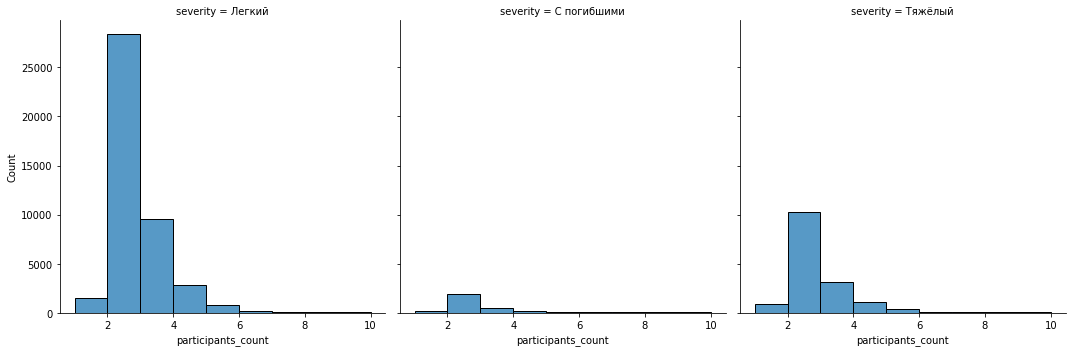

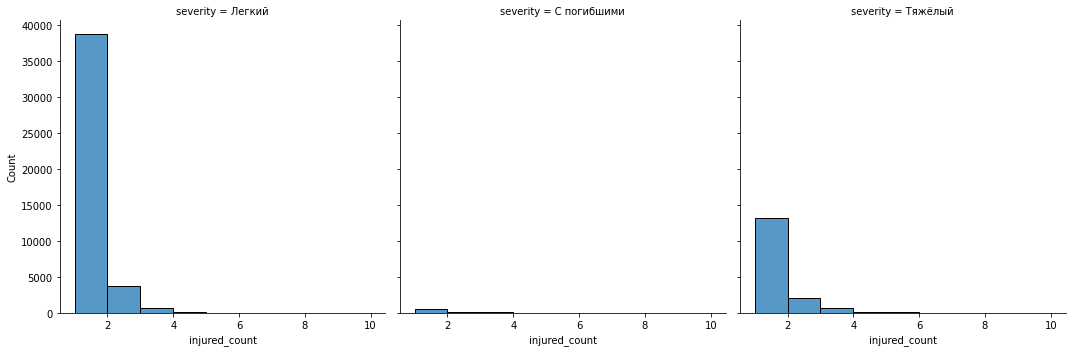

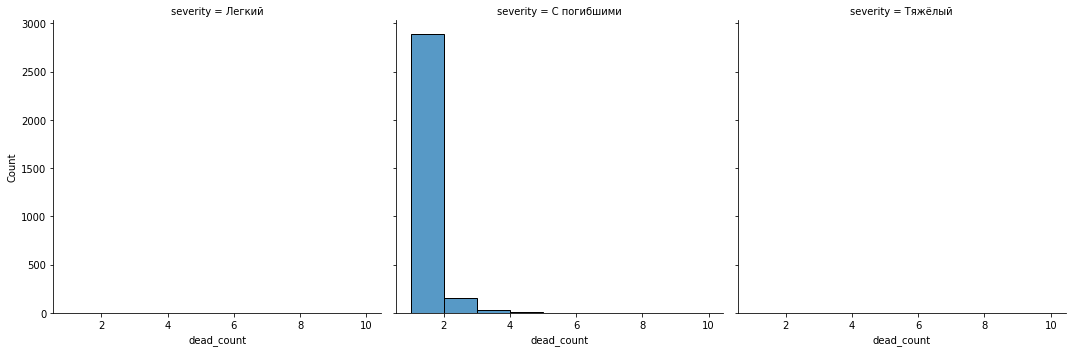

In [3]:
display(Markdown('### Распределение количества участников, пострадавших и смертей по категории Тяжесть ДТП(severity)'))
sb.displot(data=df, x='participants_count', col='severity', bins=[1, 2, 3, 4, 5, 6, 7, 10])
sb.displot(data=df, x='injured_count', col='severity', bins=[1, 2, 3, 4, 5, 6, 7, 10])
sb.displot(data=df, x='dead_count', col='severity', bins=[1, 2, 3, 4, 5, 6, 7, 10])
plt.show()

### Смертность по категориям

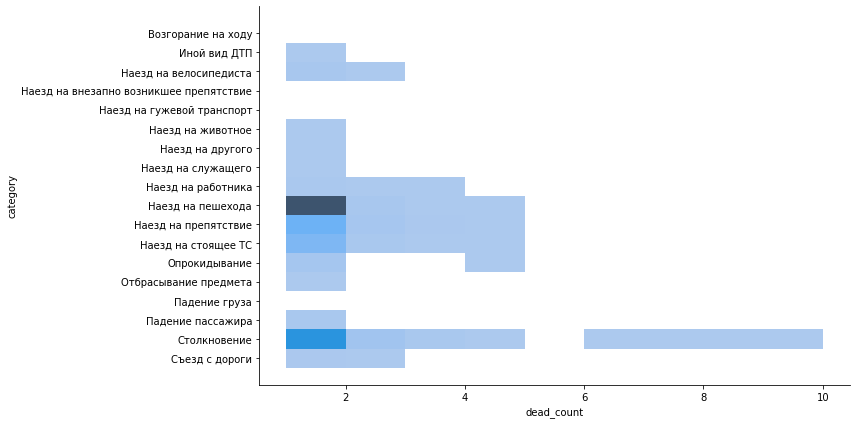

In [4]:
display(Markdown('### Смертность по категориям'))
sb.displot(df, x="dead_count", y='category', bins=[1, 2, 3, 4, 5, 6, 10, ], aspect=2, height=6)
plt.show()

### Онтошение смертности к пострадавшим

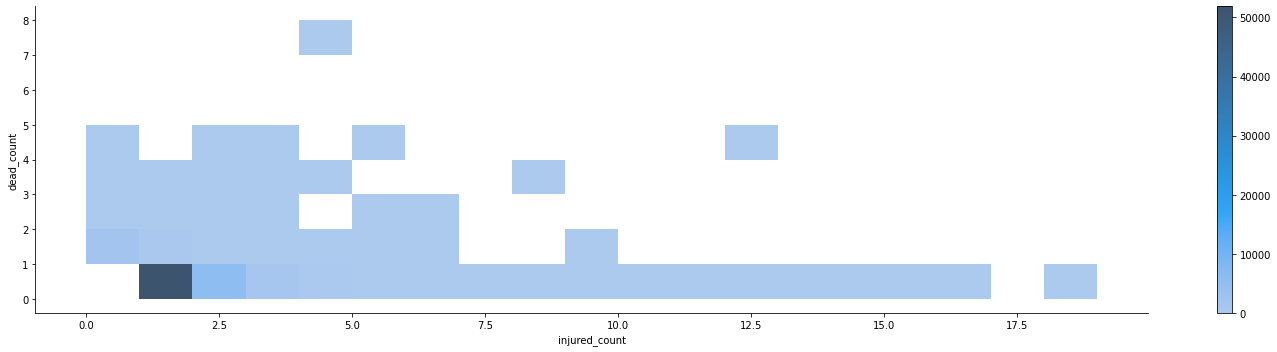

In [5]:
display(Markdown('### Онтошение смертности к пострадавшим'))
sb.displot(df, x="injured_count", y='dead_count', binwidth=(1, 1), cbar=True, aspect=4)
plt.show()

### Количество участников по дням за все время наблюдения

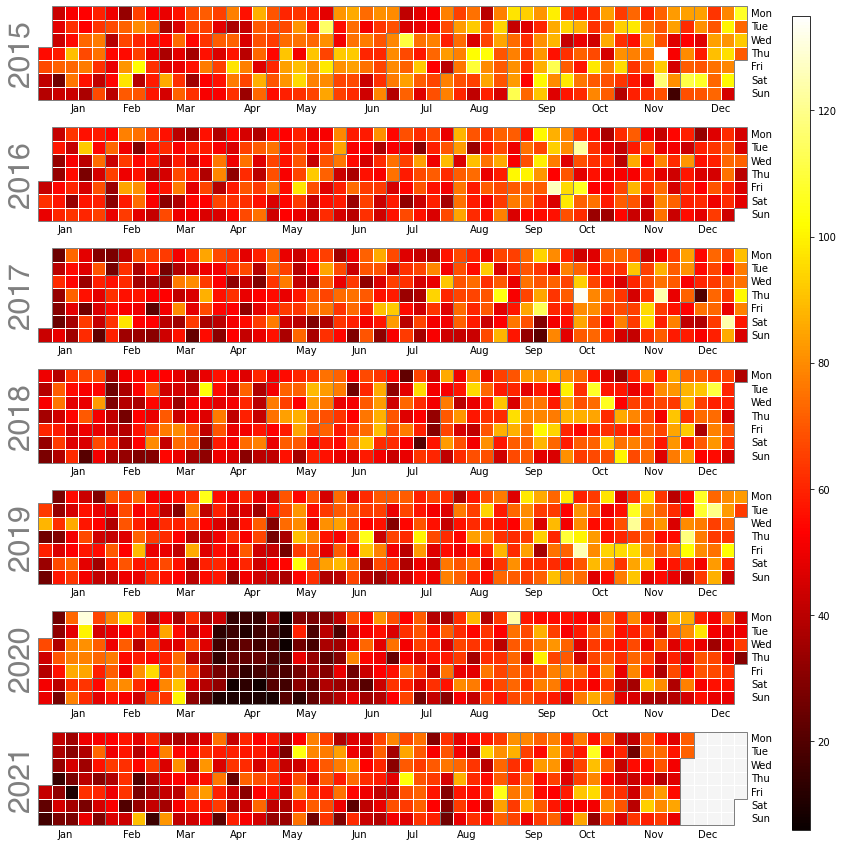

In [17]:
display(Markdown('### Количество участников по дням за все время наблюдения'))

ag = df.groupby([df['datetime'].dt.date, ]).sum()
ag.index = pd.to_datetime(ag.index)
calplot.calplot(ag['participants_count'],cmap = 'hot')
plt.show()
#plt.savefig('heat_map_moscow_2015-2021.jpeg', facecolor='w',bbox_inches="tight",)

### Корреляции признаков

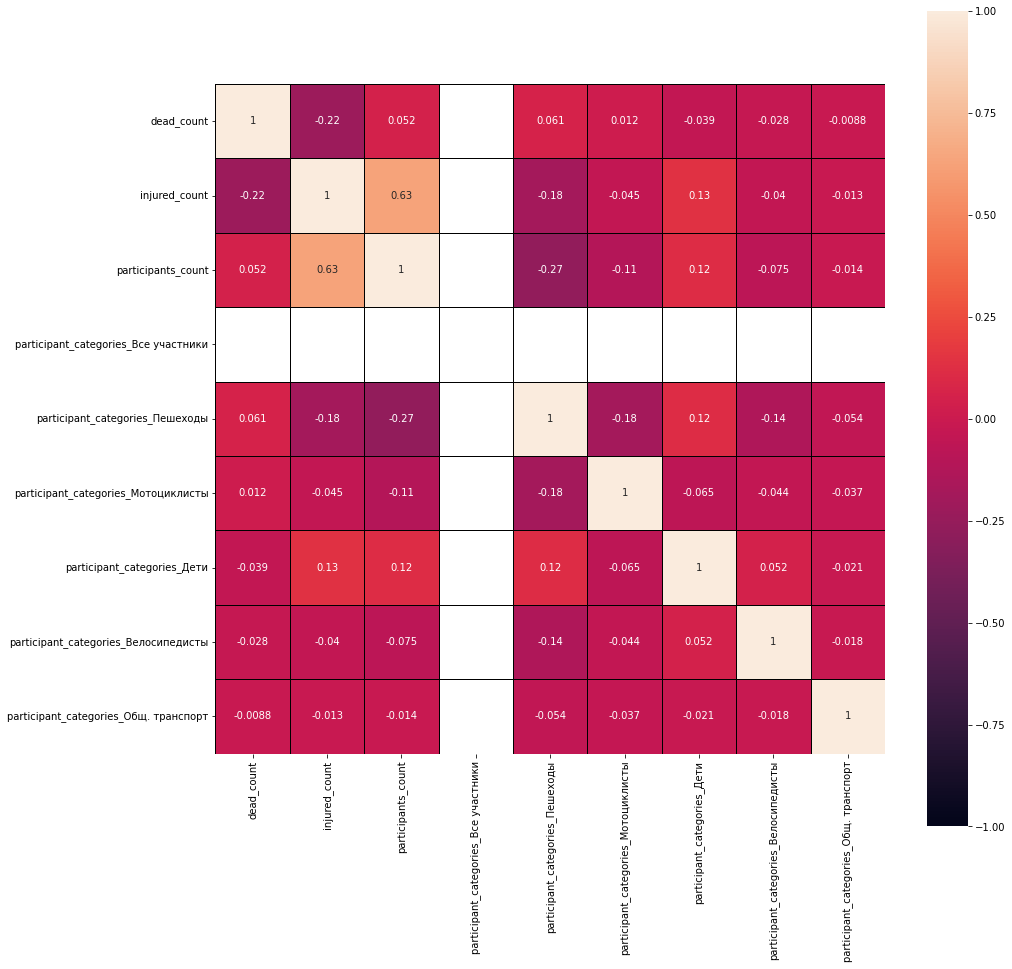

In [22]:
display(Markdown('### Корреляции признаков'))

fig=plt.gcf()
fig.set_size_inches(15,15)
sb.heatmap(df.filter(regex='^participant_categories|count|category',axis=1).corr(),annot=True,linewidths=1,linecolor='k',square=True,mask=False, vmin=-1, vmax=1,cbar_kws={"orientation": "vertical"},cbar=True)
plt.show()

## Примеры похожих исследований на Kaggle
- [Us-accidents](https://www.kaggle.com/sobhanmoosavi/us-accidents/tasks)
- [1.6 million UK traffic accidents](https://www.kaggle.com/daveianhickey/2000-16-traffic-flow-england-scotland-wales)
- [Accidents in France](https://www.kaggle.com/amadeus1996/eda-visualizations-for-accidents-in-france)